# Classification des étoiles Be selon le profil de raie Halpha


---


**Synopsis :** L’objectif de cet algorithme est d’utiliser les techniques et outils d’apprentissage automatique (i.e. Machine Learning, Deep Learning) sur un ensemble de spectres d’étoiles Be en vue d’en déduire une classification automatique des profils de raies. Les profils de raies Halpha décrits ici 
sont basés sur la codification mise en oeuvre par V. Desnoux (voir document 
"codage_profil.pdf").

**Authors :** M. Le Lain (Model Training) / V. Desnoux (Codification) / F. Cochard (Proposition)

**Licence :** ![https://www.gnu.org/licenses/quick-guide-gplv3.html](https://img.shields.io/badge/Licence-GPLv3-orange.svg?style=flat)

**Infos et contact :** [website](https://stellartrip.net)

**Version :** 1.0 - Update 08-01-2021

**Licence GPLv3 Notice :** [Guide rapide](https://www.gnu.org/licenses/quick-guide-gplv3.html)


    Classification automatique des étoiles Be selon le profil de raie Halpha
    Copyright (C) 2021  M. Le Lain (Model Training) - V. Desnoux (Codification) - F. Cochard (Proposition)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see https://www.gnu.org/licenses/.

  

---









## Introduction

Ce Notebook entraîne un modèle de classification de profile de raie Halpha à partir de spectres d'étoiles Be. Les données utilisées pour l'entrainement de ce modèle proviennent exclusivement de la [Base BeSS](http://basebe.obspm.fr/basebe/Accueil.php?flag_lang=fr)<sup>1</sup>. Un remerciement particulier à tous les contributeurs de cette base et aux personnes qui la maintienne est à noter ici, pour l'utilisation possible de toutes ces données.



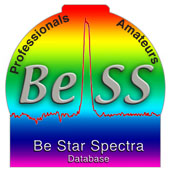. </center>


La récupération des données afin de consituer un dataset est expliquée dans un autre document (link).

Le processus de préparation des données pour l'entrainement, ainsi que les étapes d'entrainement sont décrites avant chaque cellule d'exécution de ce notebook.



L'entrainement de ce modèle est effectué avec la librairie [Fast.ai](https://www.fast.ai/)<sup>2</sup>, basé sur [PyTorch](https://pytorch.org/) <sup>3</sup>. 


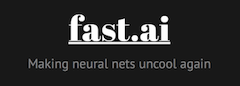







## 1 - Préparation de l'environnement

### Environnement d'execution 
Afin de tirer parti des GPU ou TPU pour l'entrainement du modèle, il est conseillé de définir l'environnement d'exécution Colab sur GPU, ou TPU.

> Exécution => Modifier le type d'exécution => Accélérateur Matériel => GPU/TPU.



### Activer l'accès au dossier GDrive

Pour accéder au dataset et avoir la possibilité d'enregistrer
des données, activer l'accès au dossier de projet si le 
notebook est exécuté sur GDrive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Pour effectuer un nouvel entrainement à partir de ce notebook, il est nécéssaire de récupérer le dataset à cette adresse (env. 80Mo) : 

[Télécharger le dataset](https://e.pcloud.link/publink/show?code=XZk6JXZs24TDASz2yXOgIQ62sC8sYfwYs0k)

Décompresser son contenu dans le dossier ha_spec, comme l'indique l'arborescence ci-dessous, à recréer dans votre dossier GDrive.

L'explication du processus entier est expliqué dans la suite de ce notebook.

```
BeAI Folder/
├── ha_spec/  # Les images qui servent à l'entrainement que vous venez de télécharger
│   ├── 0-Aea/  # Images GADF de type png des spectres annotés Aea
│   │   ├── BeSSvo_2....png
│   │   ├── BeSSvo_bess...pgn
│   │   ...
│   ├── 1-Aea/
│   │   ├── BeSSvo_6....png
│   │   ...
│   ├── 2-Ep/ 
│   ├── 3-E/ 
│   ├── 4-AE/
│   ├── 5-Ae/  
│
├── DL_Be_classif_training.ipynb # Ce notebook
├── BeAi_dataset.csv # La liste des fichiers fits initiaux utilisés

```



### Dépendances

- Fastai (v2.2.5)  Update 02/2021 Attention régression de performance sur la dernière version de Fastai v2.2.7. Attente de correctif pour mise à jour de lib.
- Fastbook
- Astropy
- Spectutils
- Pandas


Installation des librairies pour la manipulation des données et librairies d'astronomie


In [ ]:
#Generate a conflict on jsonschema at first execution
#Restart execution environment => re-run => it's ok...
#Solution not found for now (probably just define the best version lib)

#system
import time
import glob

#Install for astronomy tools
!pip install --quiet --upgrade specutils
!pip install --quiet --upgrade astropy 
!pip install --quiet --upgrade pyts
#!pip install jsonschema==3.0.2

#Maths and visualisation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
#from pyts.datasets import load_gunpoint

# astronomy import
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region
from astropy.io import fits
from astropy.units import Quantity
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below  
from astropy.time import Time
from astropy import units as u
from astropy.table import Table
from astropy import units as u

#Datas
import pandas as pd


Installation et import de la librairie Fastai.
La version utilisée est 2.2.5. (Attention performance mauvaise en v2.2.7 à vérifier sur les évolutions suivantes)

In [ ]:
#!pip install --quiet --upgrade fastai #fastai==2.2.5

!pip install fastai==2.2.5

import fastai
from fastai.imports import *

#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from fastai.vision.widgets import *

#monitoring wandb pour analyse de la performance du training
#!pip install -qqq wandb

print("Fastai version : ", fastai.__version__)
#print(fastbook.__version__)

     |████████████████████████████████| 194kB 4.9MB/s 
  Found existing installation: fastai 2.2.7
    Uninstalling fastai-2.2.7:
      Successfully uninstalled fastai-2.2.7
Fastai version :  2.2.5


Si vous disposez d'un compte https://wandb.ai/, vous pouvez lié ce notebook à votre compte via la cellule ci-dessous. Dans l'execution normale, les lignes de monitoring sont commentés.

In [ ]:
#import for extern monitoring (not necessary)
#import wandb
#from fastai.callback.wandb import *
#wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Parcours des dossiers et positionnements dans le dossier 'Training_2'

In [ ]:
%ls

gdrive/  sample_data/


In [ ]:
#change path here to your GDrive folder contains this notebook
%cd 'gdrive/My Drive/be_ai/lab_be/training_2'

[Errno 2] No such file or directory: 'gdrive/My Drive/be_ai/lab_be/training_2'
/content


## 2 - Préparation des données

---



Cette partie consiste à préparer les données brutes en vue d'entrainer le modèle de prédiction. 

**Transfer learning**

Pour effectuer les premierts tests et prototypes, une sélection plus petite est faite dans le jeu de données des spectres (i.e. 500 spectres). Comme ce jeu de donnée est plus réduit, il est plus difficile d'entrainer un modèle performant. Update 02/2021 : Finalement après quelques tests, l'entrainement n'est pas si mauvais, même avec un petit jeu de données.

Par ailleurs, l'entrainement de modèle entier avec un gros volument de données prend du temps et des ressources matérielles conséquentes.

Ainsi, pour analyser quels sont les leviers/paramètres ajustables et faire les tests, le principe du Transfer Learning est appliqué dans un premier temps.

Ce principe va permettre d'ajuster notre modèle en partant d'un modèle qui a déjà été entrainé avec des gros volumes de données, avec des images de chiens et chats par exemple. Ce modèlé pré-entrainé a déjà une architecture très performante et nous allons pouvoir lui soummettre nos données pour qu'ils les "apprenent" et qu'il ajuste ses paramètres.

Des tests d'entrainements complets et avec le jeu de données entiers seront tout de même effectués et le passage de l'un à l'autre sera fait en commentant/décommantant les lignes de codes correspondantes.

<center>-</center>

**Computer Vision**

La technique utilisée pour tester une classification des profils de raies s'appuie ici sur la vision par ordinateur (Computer Vision) basé sur les Réseaux de Neurons de Convolutions (CNN pour Convolutionnal Neural Network). 

L'architecture utilisée, qui définit de fait le type de modèle généré, sera du type ResNet (Residual Neural Network). Cette architecture est précisée dans les cellucles ci-dessous.

<center>-</center>

**Préparation de données**


- Le jeu de données contient environ 21311 spectres d'étoiles Be au format FITS sélectionnées à partir du fichier de codification cités en début de notebook. Le range de sélection de ces spectres dans la base BeSS s'étend de 6525A à 6595 et ces derniers sont placés dans le dossier de l'objet correspondant.

  Exemple : /HD4180/BeSSvo__hd4180_20160816_017_34.fits
  
  Ces spectres ont été réalisés avec différents spectroscopes, à différentes résolutions . Une sélection et régénération de la plage spectral a été effectuée pour avoir un jeu de données normalisé pour l'entrainement, de 6525A à 6595A précisémment.



- Afin de tirer parti des performances du modèle préentrainé, il est plus intéressant d'effectuer l'entrainement à partir d'image qui sont de tailles réduite(i.e. png).

- Dans notre cas, nous disposons de fichiers FITS correspondant, entre autre, à une matrice de points. Un second jeu de données d'images générées à partir de ces fichiers FITS est effectué. Toutefois, un apprentissage fait avec des png de spectres ne serait pas forcément pertinent et/ou performant.

<center>-</center>

**GADF**

Ainsi, pour augmenter la performance du modèle des graph GADF (Gramian Angular Difference Field) ont ont été générés pour chaque spectre FITS du dataset et placés dans les dossiers correspondants aux différents types de profils<sup>4</sup>.

  Exemple : /ha_spec/1-AEa/BeSSvo__10cas_20020902_934.png

  Plus d'informations sur cette méthode via les liens suivants : 
  - https://arxiv.org/abs/1608.04363 
  - https://etown.medium.com/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52

  Librairie utilisée pour la génération des graphes GADF <sup>4</sup> : [Pyts](https://pyts.readthedocs.io/en/stable/index.html)








**Résumé du processus, pour chaque spectre :**
- Ouverture du spectre original entier
- Zoom sur la région Halpha et création d'un spectre (6525 <=> 6595 A)
- Génération d'un graphe GADF au format .png


#### Définition des chemins et visualisation du Dataset

In [ ]:
#Databse for all spectrums informations
dataset_db = 'BeAi_dataset.csv'

#path for all fits spectrum
dataset_path = 'dataset/'

#path for all png spectrum by category for training
path = Path('ha_spec')

#Print 
df = pd.read_csv(dataset_db)
df

,_id,g_star_name_hd,g_star_position_ra,g_star_position_dec,g_spectral_band_start,g_spectral_band_stop,g_time_period,g_star_designation,g_star_spectral_type,g_star_magnitude,g_star_be_period,g_star_line_profil,g_star_variability_profil,g_star_variability_comments,vo_acref,vo_format,vo_data_id_title,vo_publisher,vo_location_spatial,vo_location_time,vo_location_spectral,vo_bounds_spectral,vo_spectral_si_dim,vo_flux_si_dim,vo_creator,vo_collection,vo_creator_did,vo_datasource,vo_creation_type,vo_publisher_did,vo_coord_sys_name,vo_ucd_flux,vo_ucd_spec,vo_bounds_time,vo_bounds_spectral_start,vo_bounds_spectral_stop,vo_flux_calibration,vo_spectral_calibration,vo_dataset_type,vo_curation_date,vo_curation_version,vo_curation_rights,vo_target_name,vo_target_class,vo_coord_sys_equinox,vo_bounds_time_start,vo_bounds_time_stop,head_bitpix,head_naxis,head_naxis1,head_naxis2,head_pcount,head_gcount,head_tfields,head_ttype1,head_tform1,head_tunit1,head_ttype2,head_tform2,head_tunit2,head_ttype3,head_tform3,head_tunit3,head_extname,head_voclass,head_vocreate,head_date,head_bandpass,head_specband,head_object,head_vopub,head_vologo,head_flux_ucd,head_equinox,head_radecsys,head_timesys,head_timeunit,head_specsys,head_timesdim,head_specsdim,head_fluxsdim,head_mjdref,head_spec_res,head_flux_cal,fits_bess_vo_url,fits_filename,png_filename,log_filename,dataset_add_date
0,5f8a1eff5919f532900f5988,HD225132,0d56m05.8176s,-17d20m09.5719s,6.525000e-07,6.595000e-07,NO,2 Cet,B9IVne,4.543,365,Aea,Aea-Aea,false,http://basebe.obspm.fr/cgi-bin/extBeSS.pl?fits=A_afavaro%2Fc8lhires3st7%2F_2%20Cet_20110909_969.fits,application/fits,BeSS:2 Cet,Observatoire de Paris-Meudon -> GEPI,0.9349575 -17.3359878,55813.990116,6.569841e-07,8.591992e-09,L 1.0E-10,ML-1T-3 1.0E+7,BeSS,BeSS-Spectra,BeSS:61736,observed,pointed,ivo://obspm.fr/SSAP_BESS#61736,FK5,phot.flux;em.wl,em.wl,3636.0,6.526881e-07,6.612801e-07,Uncalibrated,Calibrated,spectrum,2011-09-10,1.0,public,2 Cet,Star,2000.0,2011-09-09 23:15:27.999999,2011-09-10 00:16:03.999999,8,2,12,1462,0,1,3,WAVE,1E,Angstrom,FLUX,1E,UNKNOWN,ERROR,1E,UNKNOWN,SPECTRUM,Spectrum 1.00,Be Stars Spectra Database,2011-09-09T23:15:28,False,Optical,2 Cet,ivo://obspm.fr,http://basebe.obspm.fr/basebe/Images/LogoBeSS.jpg,phot.fluxDens;em.wl,2000,FK5,TT,s,TOPOCENT,T,10-10 L,ML-1T-3,0,0.058769,UNCALIBRATED,http://basebe.obspm.fr/cgi-bin/extBeSS.pl?fits=A_afavaro%2Fc8lhires3st7%2F_2%20Cet_20110909_969.fits,BeSSvo__2 Cet_20110909_969.fits,BeSSvo__2 Cet_20110909_969.png,HD225132.log,2020-10-16T22:30:23.441Z
1,5f8a1f065919f532900f5989,HD225132,0d56m05.8176s,-17d20m09.5719s,6.525000e-07,6.595000e-07,NO,2 Cet,B9IVne,4.543,365,Aea,Aea-Aea,false,http://basebe.obspm.fr/cgi-bin/extBeSS.pl?fits=A_afavaro%2Fc8lhires3st7%2F_2cet_20110926_899.fits,application/fits,BeSS:2 Cet,Observatoire de Paris-Meudon -> GEPI,0.9349575 -17.3359878,55830.915828,6.570523e-07,8.699365e-09,L 1.0E-10,ML-1T-3 1.0E+7,BeSS,BeSS-Spectra,BeSS:62490,observed,pointed,ivo://obspm.fr/SSAP_BESS#62490,FK5,phot.flux;em.wl,em.wl,2909.0,6.527027e-07,6.614021e-07,Uncalibrated,Calibrated,spectrum,2011-10-02,1.0,public,2 Cet,Star,2000.0,2011-09-26 21:34:33,2011-09-26 22:23:02,8,2,12,1492,0,1,3,WAVE,1E,Angstrom,FLUX,1E,UNKNOWN,ERROR,1E,UNKNOWN,SPECTRUM,Spectrum 1.00,Be Stars Spectra Database,2011-09-26T21:34:33,False,Optical,2 Cet,ivo://obspm.fr,http://basebe.obspm.fr/basebe/Images/LogoBeSS.jpg,phot.fluxDens;em.wl,2000,FK5,TT,s,TOPOCENT,T,10-10 L,ML-1T-3,0,0.058307,UNCALIBRATED,http://basebe.obspm.fr/cgi-bin/extBeSS.pl?fits=A_afavaro%2Fc8lhires3st7%2F_2cet_20110926_899.fits,BeSSvo__2cet_20110926_899.fits,BeSSvo__2cet_20110926_899.png,HD225132.log,2020-10-16T22:30:30.937Z
2,5f8a1f0e5919f532900f598a,HD225132,0d56m05.8176s,-17d20m09.5719s,6.525000e-07,6.595000e-07,NO,2 Cet,B9IVne,4.543,365,Aea,Aea-Aea,false,http://basebe.obspm.fr/cgi-bin/extBeSS.pl?fits=A_tbohlsen%2Fl200r600obj200mmsbigst8xme%2F2cetBeSS111108.fits,application/fits,BeSS:2 Cet,Observatoire de Paris-Meudon -> GEPI,0.93494934 -17.3359922,5

#### Fonctions d'affichage des spectres et génération du graphe GADF

L'ensemble de méthodes ci-dessous permet de disposer d'outils de génération d'images et de visualisations en vue de la préparation du jeu de données entier et des manipulations générales lié à ce notebook. 

- Génération de deux Spectres 1D (SpecUtils<sup>5</sup>) entiers et zoomé sur Halpha, à partir d'un fichier FITS
- Affichage rapide d'un spectre avec Matplotlib<sup>6</sup>
- Affichage rapide de deux spectres (entier et Halpha)
- Génération et enregistrement d'un graphe GADF à partir d'un spec1D.


In [ ]:
def generate_spec1Ds(fits_file_path):
  """
  This function take a FITS file for Generate two Spec1D with SpecUtils,
  entire spectrum and zoom spectrum on Halpha (6525 <> 6595 A)

  Parameters
  ----------
  fits_file_path : str
      The path for FITS file spectrum.

  Returns
  -------
  spec1D
      The spec1D object of the entire spectrum.
  spec1D
      the spec1D object of the Halpha spectrum.

  """
  f = fits.open(dataset_path + fits_file_path)

  #create global spectrum
  evt_data = Table(f[1].data)
  spec1D_global = Spectrum1D(spectral_axis=evt_data['WAVE'] * u.AA, flux=evt_data['FLUX'] * u.Jy)

  #create spectral region for Halpha line zoom (6525 <=> 6595)
  sr =  SpectralRegion(6525*u.AA, 6595*u.AA)

  #create a new spectrum of the selected region for plot
  sub_spectrum = extract_region(spec1D_global, sr)
  spec1D_Ha = Spectrum1D(flux=sub_spectrum.flux,spectral_axis=sub_spectrum.spectral_axis)
  f.close()
  return spec1D_global, spec1D_Ha 


def spec_plot(spec1D_to_plot):
  """
  Generate and show a quick plot with Matplotlib from a Spec1D

  Parameters
  ----------
  spec1D_to_plot : spec1D
      The spec1D object to plot

  """
  fig, ax1 = plt.subplots(figsize=(9,6))

  #Global
  ax1.plot(spec1D_to_plot.spectral_axis, spec1D_to_plot.flux)
  ax1.set_ylabel('Flux')
  ax1.set_title("Global Spectrum")

  #Plot
  fig.tight_layout()
  plt.show()


def spec_plots(full_spec1D, region_spec1D):
  """
  Generate and show a two plots with Matplotlib from full and zoom Spec1D

  Parameters
  ----------
  full_spec1D : spec1D
      The spec1D object full spectrum to plot
  full_spec1D : spec1D
      The spec1D object Halpha zoom spectrum to plot

  """
  #create each plot 
  fig, axs = plt.subplots(2, 1, figsize=(16,9))

  #Global
  axs[0].plot(full_spec1D.spectral_axis, full_spec1D.flux)
  axs[0].set_ylabel('Flux')
  axs[0].set_title("Global Spectrum")

  #Halpha Zoom
  axs[1].plot(region_spec1D.spectral_axis, region_spec1D.flux)
  axs[1].set_ylabel('Flux')
  axs[1].set_title("Halpha Crop")

  #Plot
  fig.tight_layout()
  plt.show()


def generate_GAF(spec_to_gaf, field_type, png_path):
  """
  Generate a GAF graph in .png and record it in the path given in parameters.

  Parameters
  ----------
  spec_to_gaf : spec1D
      The halpha zoom spec1D object
  filed_type : str
      The type of graph : difference or sum
  png_path : Path
      The path for png records

  """
  X_spec = np.array([spec_to_gaf.flux, spec_to_gaf.spectral_axis])

  #record png from specArray in folder png_path
  gaf = GramianAngularField(method=field_type)
  X_gaf = gaf.fit_transform(X_spec)

  # Show the images for the first time series
  fig_gaf = plt.figure(figsize=(5,5))
  ax_gaf = fig_gaf.add_subplot()
  plt.axis('off')
  #ax_gaf.set_title('Plot title')
  #plt.colorbar(orientation='vertical')

  #Generate plot image
  im_gaf = plt.imshow(X_gaf[0], cmap='viridis', origin='lower')
  #Save fig
  plt.savefig(png_path, dpi=100, bbox_inches='tight')
  plt.close()
 

### Parcours et génération des données d'entrainement 

L'ensemble du dataset initial est parcouru pour générer un graphe GADF pour chacun des spectres FITS et le placer dans le dossier qui correspond au profil de raie Halpha avec un index en préfixe du nom de dossier.

Détail de l'algorithme :
- Récupération du spectre initiale dans le dataset en format .FITS.
- Génération d'un spec1D sur la région Halpha.
- Génération d'un graphe GADF en .png à partir du spectre spec1D Halpha précédent.
- Enregistrement du graphe GADF dans un dossier correspondant au profil de raie associé à un préfixe d'index au sein du dossier d'entrainement (Ex : /ha_spec/1-AeA/nomfichier.png)
- Enregistrement du label (i.e. profil de raie Halpha) dans une liste (labels) si non existant
- Pause d'une seconde entre chaque itération (pas forcément indispensable, mais pour s'assurer de l'enregistrement de l'image sur le GDrive)


In [ ]:
# --------- Ce script ne doit pas être executé ---------

# Il sert à parcourir les fichiers FITS initiaux qui sont transformé en graphe GADF en png afin de créer un dataset proprice à l'entrainement. 
# Il est donné ici pour information, et peut-être utilisé si vous souhaitez générer un tout nouveaux jeu de données (i.e. autre que BeSS)

"""

#list of label
labels= []

#verif and create ha_spec training path 
if not path.exists():
  path.mkdir()

  #iterate on each row of the dataset
  for index, row in df[:500].iterrows():
    print(row['g_star_name_hd'], row['g_star_line_profil'], row['fits_filename'])

    #create label if it's not in the list
    if row['g_star_line_profil'] not in labels:
      labels.append(row['g_star_line_profil'])

    #get label index for avoid same folder name (i.e. lower/uppercase) 
    category_pos = labels.index(row['g_star_line_profil'])
    print(category_pos)
    category_path = str(category_pos) + '-' + row['g_star_line_profil']
    path_in_progress = Path(path/category_path)

    #create folder if not exist
    if not path_in_progress.exists():
      path_in_progress.mkdir(exist_ok=False)

    #generate GADF png and record in folder
    file_in_progress = row['g_star_name_hd'] + '/' + row['fits_filename']
    specs = generate_spec1Ds(file_in_progress)
    filename = path_in_progress/row['png_filename']
    generate_GAF(specs[1], 'difference', filename)

    time.sleep(1)
    if df.index == 500 | df.index == 2000 | df.index == 5000 | df.index == 10000 | df.index == 15000 :
      print(str(df.index))

print(f"Labels list : {labels}")


"""

Labels list : []


**Vérification de la présence des images dans les dossiers généré**

In [ ]:
#image files verification in the folder ha_spec
fns = get_image_files(path)
fns

#uncomment for watch get_images_files documentation
#??get_image_files

(#500) [Path('ha_spec/0-Aea/BeSSvo__2 Cet_20110909_969.png'),Path('ha_spec/0-Aea/BeSSvo__2cet_20110926_899.png'),Path('ha_spec/0-Aea/BeSSvo_2cetBeSS111108.png'),Path('ha_spec/0-Aea/BeSSvo_BeSS__2_cet_20100927_834.png'),Path('ha_spec/0-Aea/BeSSvo__2cet_20020903_047.png'),Path('ha_spec/0-Aea/BeSSvo_2 Cet 20121203.png'),Path('ha_spec/0-Aea/BeSSvo__2cet_20130903_991_afavaro.png'),Path('ha_spec/0-Aea/BeSSvo_2 Cet 20140102.png'),Path('ha_spec/0-Aea/BeSSvo_BESS_2cet_20140928_498_JPowles.png'),Path('ha_spec/0-Aea/BeSSvo_BESS_2cet_20141002_464_JPowles.png')...]

## 3 - Initialisation du DataBlock 



Le bloc ci-dessous prépare un objet DataBlock en vue d'initialiser un DataLoader.

Pour pouvoir mettre en place un DataLoader, il est nécessaire de fournir 4 choses :
- Le type de données
- Le moyen d'obtenir la liste de ces données
- La façon dont les données sont étiquetées (i.e. labels)
- Le découpage du jeu de données de validation

Les paramètres ci-dessous correspondent à ces items qui sont passés en paramètre du DataBlock. Ce dernier, faisant office de template, est ensuite passé au DataLoder.<sup>7</sup>

#### Détail des Paramètres

**-- blocks(ImageBlock , CategoryBlock)**

- ImageBlock : Variable indépendante (utilisé pour faire les prédictions), à savoir ici les images de graphes GADF.

- CategoryBlock : Variable dépendante (cible des prédictions), à savoir les profils de raies.



**-- get_items(get_images_files)**

Précise la fonction/algorithme de parcours du jeu de données utilisé pour l'entrainement du modèle. La méthode utilisée dans ce notebook est la méthode get_images_files() qui renvoie la liste de toutes les images récursivement (par défaut) à partir d'un chemin passé en paramètre. 

Tapez `??get_image_files` pour afficher la documentation de la fonction.


**-- splitter=RandomSplitter(valid_pct=0.2, seed=42)**

Le jeu de données entier d'entrainement (i.e. graphe GADF en .png) est découpé en deux parties à l'aide de RandomSplitter :

- Une partie pour l'entrainement.
- Une partie pour la validation et vérification de la performance du modèle entrainé.

Le découpage effectué ici a un ratio de 80% du jeu de données pour l'entrainement et 20% des données pour la vérification et validation (i.e. valid_pct).

Pour chacun de ces deux blocs, un algorithme sélectionne aléatoirement les données dans l'ensemble, toutefois ce partage est le même à chaque lancement de l'algorithme tant qu'on n'en change pas les valeurs paramétrées.

La génération aléatoire n'étant pas si aléatoire au sein des processeurs, cela se fait grâce au "Seed" qui définit le point de départ de la génération aléatoire de la liste. Ce même point de départ regénerera la même liste aléatoire aux prochaines exécutions, nous permettant d'établir l'amélioration de notre modèle selon les paramètres d'entrées que nous changerons dans le temps <sup>8</sup>.


**-- get_y=parent_label**

Les variables indépendantes sont généralement appelées X et les variables dépendantes (ce que nous souhaitons prédire y). La méthode parent_label présent dans la librairie fast.ai récupère le nom du dossier parent, qui correspond au nom du label de notre image.


**-- item_tfms=Resize(128)**

Les images du jeu de données d'entrainement ont déjà toutes la même taille, définit précédemment lors de la génération des graphes.
Toutefois, afin d'avoir un jeu de données le plus adapté pour l'entrainement du modèle, toutes ces images sont redéfinies avec une même taille, réduite, car le modèle va les analyser et manipuler plusieurs fois chacune. Cette étape se fait grâce à la fonction Resize(128). Elles sont ensuite intégrées dans un array conséquent, appelé tenseur (tensor).<sup>8</sup>



In [ ]:
line_profil = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

## 4 - Initialisation du Dataloader

Une fois le DataBlock créé, nous pouvons y appliquer un DataLoader avec le chemin de nos données en paramètres.

In [ ]:
dls = line_profil.dataloaders(path)

Un DataLoaders intègre la validation et l'entrainement du modèle de prédiction à la fois.

Cette classe fournit, par itération, plusieurs lots de données à traiter aux GPU.
Lors de ce parcours du DataLoader, des blocs de 64 éléments sont traités à la fois, par tenseurs.

La méthode show_batch() permet de visualiser quelques éléments d'un de ces lots de traitement.


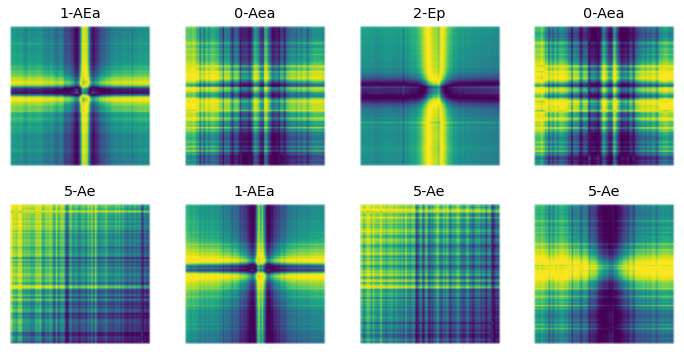

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

#### Augmentation des images




L'augmentation des données crée des variations aléatoires pour générer des données qui semblent différentes, mais sans perte les informations et leurs significations pour l'entrainement du modèle <sup>7,8</sup>. Ces variations peuvent être :
- Rotation
- Changement de luminosité
- Changement de contraste
- Déformation de perspective
- Retournement
(...)

L'augmentation se fait avec le paramètre batch_tfms qui applique ces modifications sur des lots entiers via le GPU, ce qui augmente également l'éfficacité de traitement parallélisé.



In [ ]:
line_profil = line_profil.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = line_profil.dataloaders(path)

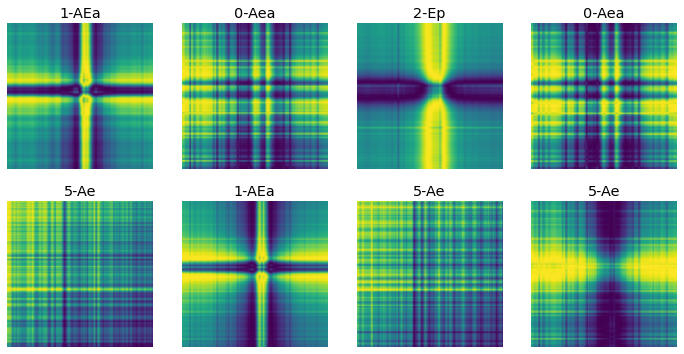

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

## 5 - Entrainement du modèle

Comme indiqué précédemment, cette étape va consister à initialiser une architecture de résaux de neurones convolutifs préentrainé (CNN<sup></sup>) en lui précisant le modèle, à savoir ici ResNet, ainsi que le type de metrique utilisé, ici error_rate.

* Error rate = 1 - accuracy = 1 - (classified correct) / (classified total)


#### Resnet

Le type de modèle utilisé ici se base sur ResNet, à savoir un réseau de neurones résiduels. Voici un description rapide de ces types de réseaux de neurones : 

"*Un réseau neuronal résiduel appelé “ResNet” est un réseau neuronal artificiel réputé. Il s’assemble sur des constructions obtenues à partir des cellules pyramidales du cortex cérébral. Les réseaux neuronaux résiduels accomplissent cela en utilisant des raccourcis ou des “sauts de connexion” pour se déplacer sur différentes couches.*" <sup>10</sup> 


L'article et les explications détaillées sont disponibles à cette adresse : [Réseaux neuronaux résiduels – Ce que vous devez savoir](https://datascience.eu/fr/apprentissage-automatique/un-apercu-de-resnet-et-de-ses-variantes/)


Sources complémentaires :

- [An Overview of ResNet and its Variants (même que le précément, mais plus complet)](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

- [Residual networks (ResNet)](https://d2l.ai/chapter_convolutional-modern/resnet.html)




**Initialisation du monitoring**

Le monitoring est lancé en parallèle avec la plateforme wandb.ai <sup>9</sup>.
Le lien vers le rapport d'entrainement monitoré est indiqué dans les cellules suivantes, une fois le modèle prêt.

In [ ]:
#wandb.init(project='be_classif_fastai');

wandb: Currently logged in as: mla (use `wandb login --relogin` to force relogin)


#### Learning Rate

Le taux d'apprentissage est un hyperparamètre qui permet qui permet d'optimiser le modèle. Ce dernier est appliqué au gradient pour faire varier le gain de gradient. <sup>11, 12</sup>

Informations complémentaires : [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay](https://arxiv.org/abs/1803.09820)


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0012022644514217973)

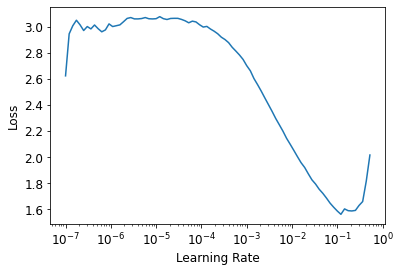

In [ ]:
#generate learner
#learn = cnn_learner(dls, resnet34, metrics=error_rate, cbs=WandbCallback()) #launch with monitoring
learn = cnn_learner(dls, resnet34, metrics=error_rate)

#determination of the learning rate
learn.lr_find()

#### Fine Tune

L'application de la méthode fine_tune, permet d'ajuster les paramètres existant sur nos modèles pré-entrainés afin de trouver les meilleurs performance pour nos nouvelles données.

Pour faire cela, la méthode déroule une epoch complète (i.e. une itération) sur l'ensemble du jeu de données pour faire une première adaptation rapide du modèle et le rendre plus efficient avec nos données.
Les autres epochs permettent elles de préciser les couches et les poids qui définiront notre modèle final.  

In [ ]:
#fine tune
learn.fine_tune(8, 3e-3)

#for training from scratch
#use : learn.fit_one_cycle(number epochs value , learning rate value)
#learn.fit_one_cycle(16, 3e-3)

#visualise train/loss plot
#learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,time
0,2.422276,1.409871,0.480000,00:57


epoch,train_loss,valid_loss,error_rate,time
0,1.153606,0.884139,0.250000,01:18
1,0.885650,0.520066,0.200000,01:24
2,0.663711,0.222177,0.060000,01:21
3,0.535020,0.099643,0.050000,01:18
4,0.465158,0.051856,0.030000,01:21
5,0.391606,0.038544,0.020000,01:19
6,0.347024,0.028613,0.020000,01:19
7,0.295353,0.029517,0.020000,01:18


In [ ]:
# Validation data access 
dl = learn.dls.valid

items= dl.items
print(len(items))
items

100


[Path('ha_spec/1-AEa/BeSSvo_10cas_20070818.png'),
 Path('ha_spec/0-Aea/BeSSvo__2cet_20090913_932_34.png'),
 Path('ha_spec/2-Ep/BeSSvo__v742cas_20191109_188_33.png'),
 Path('ha_spec/0-Aea/BeSSvo_t2cet2_1c.png'),
 Path('ha_spec/5-Ae/BeSSvo_42and_L042S05_16nov04_iu_013n39.png'),
 Path('ha_spec/1-AEa/BeSSvo__10cas_20151109_901.png'),
 Path('ha_spec/5-Ae/BeSSvo_42and_L042S05_17nov04_iu_023n39.png'),
 Path('ha_spec/5-Ae/BeSSvo_bess_HD6811_20181010.png'),
 Path('ha_spec/5-Ae/BeSSvo__phiand_20180928_984_34.png'),
 Path('ha_spec/5-Ae/BeSSvo__phiand_20150306_817_mleonardi.png'),
 Path('ha_spec/3-E/BeSSvo__omicas_20151118_846_aheidemann.png'),
 Path('ha_spec/1-AEa/BeSSvo__hd144_20171202_926_EBE.png'),
 Path('ha_spec/3-E/BeSSvo_omiCas_20120908_652.png'),
 Path('ha_spec/5-Ae/BeSSvo__phiand_20190919_973_34.png'),
 Path('ha_spec/5-Ae/BeSSvo_bess_phi_and_20130103_914.png'),
 Path('ha_spec/0-Aea/BeSSvo__hd225132_20161002_903.png'),
 Path('ha_spec/1-AEa/BeSSvo__10cas_20170201_794_34.png'),
 Path('ha_spe

In [ ]:
#generate random result prediction for monitoring/tests
from random import randint

for i in range(20):
  #get random image in dataset
  pos = randint(0, 499)
  #make prediction and create thumbnail
  pred = learn.predict(fns[pos])
  img = PILImage.create(fns[pos])
  im = img.to_thumb(48,48)

  #get initial line profil
  sp = str(fns[pos]).split('/') # split() only once

  #get prediction line profil
  print(pred[0])

  #get accuracy
  acc = str(round((pred[2][pred[1].item()].item()*100),4)) + '%'
  print(acc)

  #save log
  res = "Ground truth : " + sp[1] + " \n " + " Prediction : " + str(pred[0]) + " \n " + "Accuracy : " + acc
  #wandb.log({"Actual-Predict-Accuracy": [wandb.Image(im, caption=res)]})
 # im


5-Ae
96.8244%


3-E
56.8118%


5-Ae
90.5095%


5-Ae
86.119%


5-Ae
94.5159%


5-Ae
74.9577%


5-Ae
94.9572%


5-Ae
41.811%


5-Ae
98.4721%


5-Ae
99.1918%


2-Ep
43.5393%


5-Ae
98.3638%


3-E
96.4834%


5-Ae
55.9058%


5-Ae
81.425%


5-Ae
94.3006%


3-E
69.3677%


5-Ae
99.3673%


5-Ae
49.2892%


5-Ae
97.6247%


#### Résultats

Affichage d'un jeu d'éléments du set de test. Affiche le graphe, la prédiction et la valeur réelle de l'image. (Vert si la prédiction est bonne, rouge sinon).

In [ ]:
#some predictions
#learn.show_results()
#show all validation set preds
learn.show_results(max_n=120)

Output hidden; open in https://colab.research.google.com to view.

## 6 - Analyse de la précision et des erreurs

#### Matrice de confusion

La matrice de confusion permet de visualiser rapidement le volume d'image qui a été correctement classée ou non.

Les colonnes indiquent les images prédites par le modèle selon leurs labels, et les lignes les valeurs réelles de ces dernières. Ainsi, la diagonale permet de visualiser les bonnes prédictions.

En dehors de cette diagonale se trouvent les images qui n'ont pas été correctement classées par le modèle.

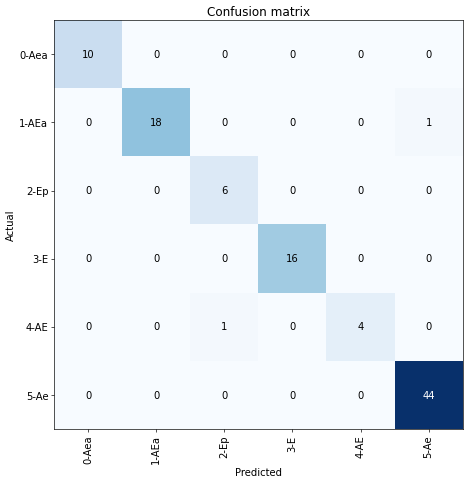

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

#### Affichage des erreurs

À partir de l'objet ClassificationInterpretation précédent, nous pouvons appliquer la méthode plot_top_losses qui fait état du nombre de pertes et mauvaises prédictions. 

Cette méthode affiche les images avec le 'loss' le plus élevées, et donc probablement le plus grand risque d'erreur.

Les images en sorties sont affichées avec quatre valeurs :
- Le label de la prédiction
- Le label réel (profil de raie)
- La perte
- La probabilité (niveau de confiance de la prédiction attribué par le modèle)


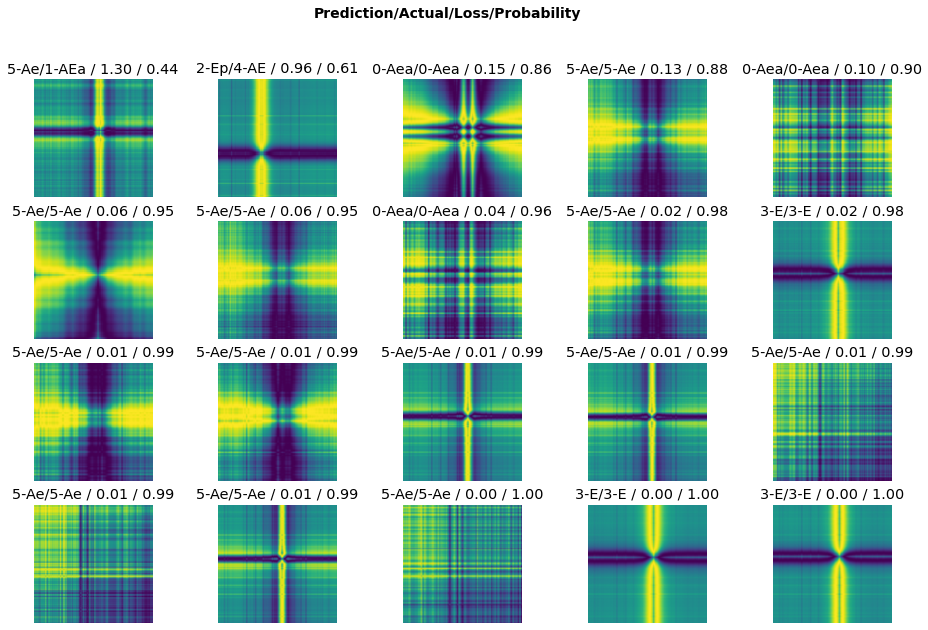

In [ ]:
#interp_learn = Interpretation.from_learner(learn)

#Show top loss
interp.plot_top_losses(20, figsize=(16,10)) #, nrows=2)

**Clôture du monitoring**

In [ ]:
#wandb.finish()

epoch,17
train_loss,0.14254
raw_loss,0.09991
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.94995
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▇▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,██▆▅▄▃▃▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,█▆▁██▇▆▅▅▄▃▂▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▃█▂▂▂▂▃▃▄▄▄▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


**Rapport de supersivion**

Le rapport de supervision de l'entrainement avec 500 spectres généré via wandb.ai est disponible ici : [Report - 16/01/2020](https://wandb.ai/mla/be_classif_fastai/reports/Halpha-Line-Classification-of-Be-Stars--Vmlldzo0MTExNDU?accessToken=969582mb6u4rqzzmupmkthpbafev0tr2yu3q1g4ddx02v6whojhyvwv1je806806)

## 7 - Predictions

Une analyse plus poussée devra être faite pour évaluer la performance du modèle plus précisément, et estimer l'intérêt d'une mise en exploitation.

Le modèle a évalué son entrainement avec des données de tests qu'il n'a pas connu pendant l'entrainement. Toutefois, afin de pouvoir évaluer au plus juste sa performance, il sera intéressant de lui soumettre des données externes nouvelles et analyser ses prédictions.

Malgré tout, nous pouvons dès à présent effectuer quelques tests en prenant des données aux hasards dans notre Dataset, comme dans le bloc ci-dessous.



#### Prédiction à partir d'un fichier PNG GADF
---

In [ ]:
#Precise file in ha_spec path here for check prediction
image_path_ha_spec = fns[10]

print(f'Prediction for file : {image_path_ha_spec} \n')
pred = learn.predict(fns[10])

pred1 = str(round((pred[2][0].item()*100),3)) + ' %'
pred2 = str(round((pred[2][1].item()*100),6)) + ' %'
p = {'Class Pred.': [(pred[0].split('-'))[1]], 'Accuracy Pred.': pred1, 'Second Pred.': pred2}
d = pd.DataFrame(data=p)
d

Prediction for file : ha_spec/0-Aea/BeSSvo_20141027-201750-2Cet-5x300s-P_1C_34.png 



,Class Pred.,Accuracy Pred.,Second Pred.
0,Aea,99.999 %,0.000445 %


#### Affichage du spectre et GADF

Affichage du spectre et du Graphe GADF

Ce script recherche le fichier FITS présent dans le dataset initial à partir du nom de fichier png. (**Necéssite d'avoir le dossier dataset FITS initial**).

In [ ]:
#Mise en méthode 

def preds_and_show_graph(image_ha_path_to_preds):
  #print("\n --- Get init FITS Spectrum and plot --- )"
  sp = str(image_ha_path_to_preds).split('/') # split() only once
  #print(sp[2:])
  fold = sp[1]
  file = sp[2]
  exten = os.path.splitext(sp[2])
  print("Initial Profil folder: ", fold)
  print("Spectrum Filename : ", exten[0])

  #Recursive search in dataset for retrieve initial fits file for plot
  files = [f for f in glob.glob(dataset_path + "**/" + exten[0] + ".fits", recursive=True)]
  for f in files:
      print("Path : ",f)
      s1, s2 = generate_spec1Ds(str(f.split('dataset/')[1]))
      spec_plots(s1,s2)

  #Print GADF
  print("\n GADF Path : ", image_path_ha_spec)
  im = Image.open(fns[10])
  im.to_thumb(256,256)



In [ ]:
#dl = learn.dls.valid
#.items)
 #Accès aux données de validation
dl = learn.dls.valid
validation_items = dl.items

for item_in_progress in validation_items:
  #print(item_in_progress)
  preds_and_show_graph(item_in_progress)


Initial Profil folder:  0-Aea
Spectrum Filename :  BeSSvo_20141027-201750-2Cet-5x300s-P_1C_34
Path :  dataset/HD225132/BeSSvo_20141027-201750-2Cet-5x300s-P_1C_34.fits


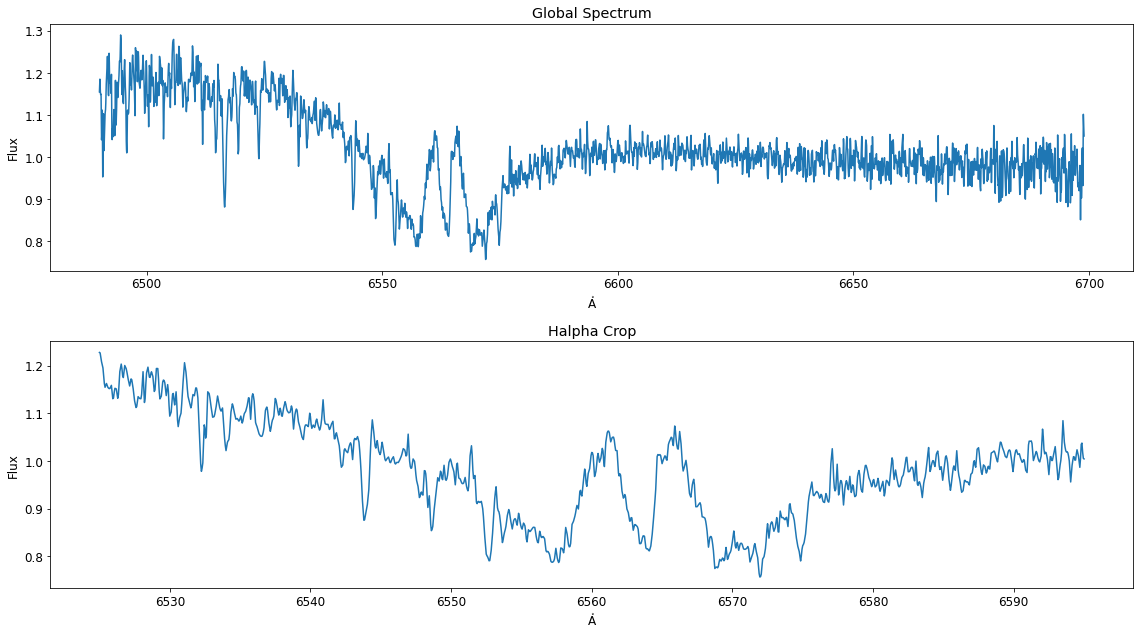


 GADF Path :  ha_spec/0-Aea/BeSSvo_20141027-201750-2Cet-5x300s-P_1C_34.png


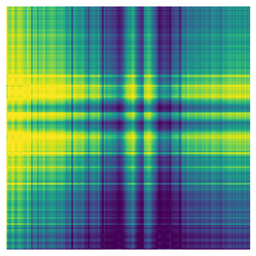

In [ ]:
#print("\n --- Get init FITS Spectrum and plot --- ")
sp = str(image_path_ha_spec).split('/') # split() only once
#print(sp[2:])
fold = sp[1]
file = sp[2]
exten = os.path.splitext(sp[2])
print("Initial Profil folder: ", fold)
print("Spectrum Filename : ", exten[0])

#Recursive search in dataset for retrieve initial fits file for plot
files = [f for f in glob.glob(dataset_path + "**/" + exten[0] + ".fits", recursive=True)]
for f in files:
    print("Path : ",f)
    s1, s2 = generate_spec1Ds(str(f.split('dataset/')[1]))
    spec_plots(s1,s2)

#Print GADF
print("\n GADF Path : ", image_path_ha_spec)
im = Image.open(fns[10])
im.to_thumb(256,256)


## 8 - Export du modèle

#### Export

Maintenant que le modèle est généré et qu'il semble pertinent, nous pouvons l'exporter afin de l'intégrer dans une application externe pour exploitation et catégorisation de nouveaux spectres d'étoiles Be.

La méthode utilisée pour cet export est export(). Cette dernière enregistre l'architecture du modèle, les paramètres définis, mais également la génération du Dataloaders.<sup>8</sup>

Lors de l'export du modèle par la librairie fast.ai, le fichier va être nommé *export.pkl*.

In [ ]:
learn.export()

#export verification 
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

#### Utilisation de l'inférence

Le fichier exporté va permettre de créer une inférence et effectuer des prédictions dans une application externe. 

Toutefois, nous pouvons déjà l'utiliser via ce notebook pour faire des tests, en créant notre *inference learner* avec la méthode *load_learner()*.

Une particularité importante sera à prendre en compte pour l'exploitation du modèle de prédiction, à savoir le format de données en entrée. En effet, le modèle ayant été entrainé par les graphes GADF à partir des spectres. Bien que totalement transparent pour l'utilisateur, il sera nécessaire de traiter nos données à analyser avec cette même transformation avant soumission au modèle. Les méthodes utilisées via ce notebook pourront cependant être réutilisées.


In [ ]:
learn_inf = load_learner(path/'export.pkl')

Donnons maintenant à notre inférence, un fichier pour prédiction.

L'obejt retourné contient trois parties :
- Le label prédit.
- L'index de la catégorie prédite
- Les probabilités de chacun des labels pour cette prédiction

In [ ]:
learn_inf.predict('path/image_to_predict')

À partir de cette prédiction, il est possible d'accéder au DataLoaders en tant qu'attribut et d'afficher la liste des labels.


In [ ]:
learn_inf.dls.vocab

## Sources et informations complémentaires

<sup>1</sup> [BeSS Database](http://basebe.obspm.fr/basebe/Accueil.php?flag_lang=fr)

<sup>2</sup> [fast.ai](https://www.fast.ai/)

<sup>3</sup> [PyTorch](https://pytorch.org/)

<sup>4</sup> [Pyts - GADF](https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_gaf.html#sphx-glr-auto-examples-image-plot-gaf-py)

<sup>5</sup> [SpecUtils](https://specutils.readthedocs.io/en/stable/index.html#)

<sup>6</sup> [Matplotlib](https://matplotlib.org/)

<sup>7</sup> [Fast.ai - Docs](https://docs.fast.ai/)

<sup>8</sup> [Deep Learning for Coders with Fastai and Pytorch](https://www.amazon.fr/Deep-Learning-Coders-Fastai-Pytorch/dp/1492045527)


<sup>9</sup> [Wandb.ai](https://wandb.ai/)

<sup>10</sup>[ResNet](https://en.wikipedia.org/wiki/Residual_neural_network)

<sup>11</sup>[Learning Rate](https://en.wikipedia.org/wiki/Learning_rate)

<sup>12</sup>[Réduction de la perte : le taux d'apprentissage
](https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate?hl=fr)


## Suite des réflexions

#### **- Classification avec label unique**

Cette classfification peut-être utilisé en production pour une exploitation rapide et concrète. Un exemple est disponible à cette adresse : https://share.streamlit.io/matthieulel/be-stars-ai-classification/main/be-classif-prod.py

Exemple 1 : un nouveau spectre d'étoile Be peut être soumis au modèle pour détecter le profil de raie Halpha rapidement. Une validation humaine lors d'une soumission d'un nouveau spectre permettrait d'ajouter cette informations dans un champs d'une base de données par exemple.

Exemple 2 : Pour tenter, à postériori avec un nouveau modèle notamment, de détecter des corrélations sur un jeu de données importants, un ensemble de spectres, peuvent être soumis pour détection. C'est ce qui a été fait sur l'ensemble des données du dataset initial (i.e. 21133 spectres). Les prédictions sont correctes, cela fera l'object de publication d'un nouveau notebook.

#### **- Classification avec labels multiples**

La prochaine évolution de ce modèle, pour tests, concerne l'entrainement du modèle avec plusieurs labels pour intégrer les variations de profils de raies qui sont listés dans la codification initiale. Cela ne sera possible qu'avec des spectres hautes résolutions. Et, dans tous les cas, à tester.


####**- Classification non-supervisée**

Par curiosité, des tests d'entrainement non-supervisés (i.e. sans préciser les labels lors de l'entrainement) seraient intéressants à effectuer. Cela permettrait de voir si d'autres découpages/corrélations/informations se dégagent des données.


#### **- Timeseries**

Afin de pouvoir prédire/analyser les évolutions des profils de raies Halpha dans le temps, l'entraînement d'un prototype de modèle de Timeserie sera a effectuer pour essayer de détecter les potentielles futures évolutions. Voir Notebook N°2 (Affichage des prédictions d'un ensemble de spectre pour une étoile données dans le temps afin de visualiser l'évolution de la raie). Et Notebook N°3 (Test d'une modèle d'apprentissage de Timeseries pour détection de saisonnalité, etc..)

